## Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import transformers
import torch
import shap
import scipy as sp
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')

## Experiment Setup

Model and Dataset

In [2]:
from utils.models import *
from utils.samples import *
from utils.functional import *
from utils.configs import *
from utils.processing import *
from functools import partial, wraps

# model_name = 'openllama'
# model_name = 'Llama2'

# model_name = 'GPT-J'
# model_name = 'falcon7b'
model_name = 'mpt7b_instruct'

data_name = 'COS-E'
exp_name = model_name+'_'+data_name

model_config = {
    'GPT-J': gpt_j_config,
    'falcon7b': falcon7b_config,
    'mpt7b_instruct': mpt7b_instruct_config,
    
}[model_name]
print(model_config)

get_model_function = {
    'GPT-J': partial(get_model_general, 'nlpcloud/instruct-gpt-j-fp16'),
    'falcon7b': partial(get_model_general, "tiiuae/falcon-7b"),
    'mpt7b_instruct': partial(get_model_general, "mosaicml/mpt-7b-instruct"),
    'openllama': get_openllama_auto,
    'Llama2': get_llama2,
}

QA_prompt_sample_dict = {
    'GPT-J': gpt_j_Zeroshot_QA_samples_new,
    'falcon7b': falcon7b_Zeroshot_QA_samples_new,
    'mpt7b_instruct': mpt7b_instruct_Zeroshot_QA_samples_new,
}

prompt_creator_dic = {
    'GPT-J': gpt_j_generate_zeroshot_prompt_QA,
    'falcon7b' : falcon7b_generate_zeroshot_prompt_QA,
    'mpt7b_instruct': mpt7b_instruct_generate_zeroshot_prompt_QA,
} 

processing_classes = {
    'mpt7b_instruct': mpt7b_instruct
}

model_processing = processing_classes[model_name]()


{'nle_generation': {'total_trials': 4, 'length_increment': 512, 'max_length': 1024}, 'generation_configs': {'renormalize_logits': True, 'early_stopping': True, 'penalty_alpha': 0.3, 'top_k': 12, 'use_cache': True}}


In [3]:
from utils.data import get_CommonsenseQA
df = get_CommonsenseQA()
generator, tokenizer = get_model_function[model_name]()

if not os.path.exists(f'../generated_nle/{exp_name}/'):
    os.makedirs(f'../generated_nle/{exp_name}/')

shap_gen_dict = dict(
    # configs set up here

    pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
    **model_config['generation_configs']
)
sample_size = 1600

Instantiating an MPTForCausalLM model from C:\Users\sonne/.cache\huggingface\modules\transformers_modules\mosaicml\mpt-7b-instruct\925e0d80e50e77aaddaf9c3ced41ca4ea23a1025\modeling_mpt.py
You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
shap_gen_dict = dict(
    # configs set up here
    max_new_tokens=12, # this value could be associated with COS
    no_repeat_ngram_size=12, # I think this should associates with the above
    pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
    **model_config['generation_configs']
)

## Get Explanations and SHAP score

### Define Generative functions

In [5]:
from utils.functional import *
from utils.samples import * 
import re

def generate_answers(batched_input_premise, batched_input_choices, batched_input_label, batched_label_idx):
    model_answers_list = []
    for i in range(len(batched_input_premise)):
        # create model specific prompt
        # input_choice_list = [phrase.strip("'") for phrase in batched_input_choices[i].split(", ")]
        input_choice_list = [phrase.strip("\"") for phrase in batched_input_choices[i].split(", ")]

        max_choice = max(len(tokenizer(ch)) for ch in input_choice_list)
        # max_new_tokens = max_choice + 4 # 2 for the two special tokens
        # no_repeat_ngram_size = max_new_tokens + 2
        # max_new_tokens = 12
        # no_repeat_ngram_size = 12 # maybe should remove this
        
        prompt = model_processing.generate_zeroshot_prompt_QA(
            batched_input_premise[i], 
            batched_input_choices[i], 
            batched_input_label[i], 
            batched_label_idx[i]
        )
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
        outputs = generator.generate(
            input_ids=input_ids,
            # input format related config
            # max_new_tokens=max_new_tokens, # this value could be associated with COS
            # no_repeat_ngram_size=no_repeat_ngram_size, # I think this should associates with the above

            # output format related config
            return_dict_in_generate=True,
            output_scores=True,

            # add config specify to the model, to tell it how to search for the answer
            **shap_gen_dict
        )
        model_generated_text = tokenizer.decode(outputs.sequences[0])
        model_answer = model_processing.get_answer_from_output_text(model_generated_text, input_choice_list, i) # get the last answer that is answered by the model
        model_answers_list.append(model_answer)
    return model_answers_list

def generate_explanation(batched_input_premise, batched_input_choices, batched_input_label, batched_label_idx):
    nle_list = []
    for i in tqdm(range(len(batched_input_premise)),leave=False):
        # trials = model_config['nle_generation']["total_trials"]
        prompt = model_processing.generate_zeroshot_prompt_QAE(
            batched_input_premise[i], 
            batched_input_choices[i], 
            batched_input_label[i], 
            batched_label_idx[i]
        )
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
        outputs = generator.generate(
            # input format related config
            input_ids=input_ids,
            # max_new_tokens=256,
            # no_repeat_ngram_size=16,
            max_new_tokens=128, # mpt7b_instruct
            no_repeat_ngram_size=5, # mpt7b_instruct
            pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
            # output format related config
            return_dict_in_generate=True,
            output_scores=True,
            # generation related config
            **model_config['generation_configs'],
        )
        prompt = tokenizer.decode(outputs.sequences[0])
        # final_explanation = re.findall('Explanation: (.*\n*.*)\n', prompt)[-1]
        final_explanation = model_processing.get_explanation_from_output_text(prompt, i)
        nle_list.append(final_explanation)
    return nle_list


### Get NLE

In [ ]:
df = get_CommonsenseQA()
last_df = df.loc[len(df)-10:]
for idx, x in last_df.iterrows():
    print(x['question'])
    print([x[f'choice_{i}'] for i in range(5)])
    print(x.label)
    print()
# print(df.loc[len(df)-10:].question.values)
# print(df.loc[len(df)-10:].values)
# print(df.loc[len(df)-10:].question.values)



small experiments

In [10]:
from utils.samples import *
from utils.functional import *
import re

idx = 33

prompt = model_processing.generate_zeroshot_prompt_QA(
    batched_input_premise[idx], 
    batched_input_choices[idx], 
    batched_input_label[idx], 
    batched_label_idx[idx]
)
input_choice_list = [phrase.strip("\"") for phrase in batched_input_choices[idx].split(", ")]

max_choice = max(len(tokenizer(ch)) for ch in input_choice_list)
# max_new_tokens = max_choice + 6 # 2 for the two special tokens
# no_repeat_ngram_size = max_new_tokens + 2
max_new_tokens = 12
no_repeat_ngram_size = max_new_tokens

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
outputs = generator.generate(
    input_ids=input_ids,
    max_new_tokens = max_new_tokens,
    no_repeat_ngram_size = no_repeat_ngram_size,
    # output format related config
    return_dict_in_generate=True,
    output_scores=True,

    # add config specify to the model, to tell it how to search for the answer
    **shap_gen_dict
)
model_generated_text = tokenizer.decode(outputs.sequences[0])
model_answer = model_processing.get_answer_from_output_text(model_generated_text, input_choice_list, idx) # get the last answer that is answered by the model
model_answer

0

Generate Answers

In [ ]:
sample_df = df[:sample_size].copy()
sample_df['nle'] = None
batch_size = 160


for i in tqdm(range(0, len(sample_df), batch_size)):
    s_range = range(i, min(i+batch_size, len(sample_df)))
    batched_input_premise = sample_df.question[s_range].tolist()
    batched_input_choices = model_processing.create_choices(sample_df.loc[s_range], add_prefix=False)
    batched_input_label = model_processing.make_choice(sample_df.loc[s_range])
    batched_label_idx = [int(sample['label']) for _,sample in sample_df.loc[s_range].iterrows()]
    # break
    model_answers_list = generate_answers(
        batched_input_premise, 
        batched_input_choices, 
        batched_input_label,
        batched_label_idx
    )
    sample_df.loc[s_range, 'model_answer'] = model_answers_list
    sample_df.to_csv(f'../generated_nle/{exp_name}/{sample_size}_{min(sample_size, i+batch_size)}_model_answers.csv', index=False)
sample_df

In [15]:
sample_df[~sample_df['model_answer'].isna()]


id  \
0     075e483d21c29a511267ef62bedc0461   
1     61fe6e879ff18686d7552425a36344c8   
2     02e821a3e53cb320790950aab4489e85   
3     23505889b94e880c3e89cff4ba119860   
4     e8a8b3a2061aa0e6d7c6b522e9612824   
...                                ...   
1595  709912a9876e824ea97da15170fd1716   
1596  95703127228d8b87b3fe998b1b2203e6   
1597  f7216534fcff2743cc94c29cb689ea71   
1598  374e8dc01ca7749d668ed66ac4044e70   
1599  f35bd5f5baf09e8836dd08cfe77a6d34   

                                               question           choice_0  \
0     The sanctions against the school were a punish...             ignore   
1     Sammy wanted to go to where the people were.  ...         race track   
2     Google Maps and other highway and street GPS s...      united states   
3     The fox walked from the city into the forest, ...    pretty flowers.   
4     What home entertainment equipment requires cable?        radio shack   
...                                                 ...                ...   
1595  Where might you have to pay for a shopping bag...         restaurant   
1596        Where would the Air Force keep an airplane?   airport terminal   
1597                       What is a computer terminal?  electrical device   
1598  She was known for be soft and sensitive, but w...      non sensitive   
1599  There are many dance clubs and higher rates of...      united states   

             choice_1         choice_2               choice_3  \
0             enforce    authoritarian                yell at   
1     populated areas       the desert              apartment   
2              mexico      countryside                  atlas   
3           hen house  natural habitat              storybook   
4          substation          cabinet             television   
...               ...              ...                    ...   
1595           closet     at starbucks            supermarket   
1596    military base              sky                 hanger   
1597          battery      electronics  transportation system   
1598        resistant            stoic               hardened   
1599             ohio             toun               michigan   

                   choice_4  label  \
0                     avoid      0   
1                 roadblock      1   
2                    oceans      3   
3              dense forest      2   
4                      desk      3   
...                     ...    ...   
1595                   home      3   
1596        airplane hangar      1   
1597                initial      0   
1598               uncaring      2   
1599  fast food restaurants      0   

                                  human_expl_open-ended   nle model_answer  
0           Not sure what else could be a common ground  None            1  
1                    People will be in populated areas.  None            1  
2     atlases were collections of highway and street...  None            2  
3     Usually the habitat of a fox is forest and it ...  None            2  
4     television is the only option that is a home e...  None            3  
...                                                 ...   ...          ...  
1595  A supermarket is the only place one would need...  None            0  
1596            is the best since it is the best backup  None            4  
1597  An computer is an electrical device connected ...  None            0  
1598  Soft and senstive persons aren't expected to b...  None            1  
1599  United states are commonly associated with obe...  None            0  

[1575 rows x 11 columns]

Generate Explanation from Model Answers

In [69]:
idx = 40
prompt = model_processing.generate_zeroshot_prompt_QAE(
    batched_input_premise[idx], 
    batched_input_choices[idx], 
    batched_input_label[idx], 
    batched_label_idx[idx]
)
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(generator.device)
outputs = generator.generate(
    # input format related config
    input_ids=input_ids,
    max_new_tokens=128,
    no_repeat_ngram_size=5,
    pad_token_id=tokenizer.eos_token_id, # to suppress open generation error
    # output format related config
    return_dict_in_generate=True,
    output_scores=True,
    # generation related config
    **model_config['generation_configs'],
)
prompt = tokenizer.decode(outputs.sequences[0])
# final_explanation = re.findall('Explanation: (.*\n*.*)\n', prompt)[-1]
final_explanation = model_processing.get_explanation_from_output_text(prompt, i)
print(prompt)
final_explanation

Based on commonsense:
Question: 
Where could a fungus grow and not be disturbed by sunlight? 
Choices: 
"under rocks", "manhattan", "toenails", "grocery store", "fallen tree" 
The best choice is: 
"under rocks"
Explanation: 
Fungi are organisms that live in soil and decompose organic matter. They are not photosynthetic, so they do not need sunlight to survive. They can grow in dark, damp places such as under rocks, fallen trees, and the soil in your garden.<|endoftext|>#

A: The best choice is "under rocks" because fungi are organisms that live under rocks and in soil. They do not need sunlight for survival.<|endoftext|>#
<|endoftext|>Q:
Where could a mushroom grow and not be affected by sunlight?
A:
Mushrooms are fungi, and like other fungi, they do not need light to


'Fungi are organisms that live in soil and decompose organic matter. They are not photosynthetic, so they do not need sunlight to survive. They can grow in dark, damp places such as under rocks, fallen trees, and the soil in your garden.'

In [ ]:
sample_df = pd.read_csv(f"../generated_nle/{exp_name}/1600_1600_model_answers.csv")
batch_size = 160
for i in tqdm(range(0, len(sample_df), batch_size)):
    s_range = range(i, min(i+batch_size, len(sample_df)))
    batch_samples = sample_df.loc[i:i+batch_size-1]
    has_answer = ~batch_samples['model_answer'].isna()
    batch_samples = batch_samples[has_answer]
    batched_input_premise = batch_samples.question.tolist()
    batched_input_choices = model_processing.create_choices(batch_samples, add_prefix=False)
    batched_input_label = model_processing.make_choice(batch_samples, key = 'model_answer')
    batched_label_idx = [int(sample['model_answer']) for _,sample in batch_samples.iterrows()]
    # break
    list_nle = generate_explanation(
        batched_input_premise, 
        batched_input_choices, 
        batched_input_label,
        batched_label_idx
    )
    valid_range = np.array(s_range)[has_answer]
    sample_df.loc[valid_range, 'nle'] = list_nle
    sample_df.to_csv(f'../generated_nle/{exp_name}/{sample_size}_{min(sample_size, i+batch_size)}_model_answer_nle.csv', index=False)
sample_df.head()

In [42]:
import re

# The input text containing the explanation
input_text = """asdfa Explanation: 
"money" is not a commonsense answer, because money is not the reason why people shop. 
"time" is not a good answer, because people can always find time to shop. 
The other choices are not commonsense answers.<|endoftext|> dhfasdf<<<"""

# Define a regex pattern to match the explanation content
pattern = r'Explanation: ([\w\W]*?)\<\|?'

re.findall(pattern, input_text)

['\n"money" is not a commonsense answer, because money is not the reason why people shop. \n"time" is not a good answer, because people can always find time to shop. \nThe other choices are not commonsense answers.']

In [7]:
file_name = "model_answer_nle"
sample_df = pd.read_csv(f'../generated_nle/{exp_name}/1600_1600_{file_name}.csv')
sample_size = len(sample_df)
sample_df = sample_df.dropna(subset=['nle'])
def has_period(text):
    ret = []
    for i, x in enumerate(text):
        if type(x) == float:
            print(i, x)
        ret.append("." in x[-10:])
    return np.array(ret)
invalid_condition = sample_df['nle'].str.contains('a chess set') | False==has_period(sample_df['nle'])
valid_samples = sample_df[~invalid_condition]
# sample_df = valid_samples
# sample_df = sample_df.reset_index(drop=True)
valid_samples.to_csv(f'../generated_nle/{exp_name}/valid_samples_{sample_size}_{file_name}.csv', index=False)
valid_samples

id  \
0     075e483d21c29a511267ef62bedc0461   
1     61fe6e879ff18686d7552425a36344c8   
2     02e821a3e53cb320790950aab4489e85   
3     23505889b94e880c3e89cff4ba119860   
4     e8a8b3a2061aa0e6d7c6b522e9612824   
...                                ...   
1594  c93572908733782a2531831bf345811a   
1595  709912a9876e824ea97da15170fd1716   
1596  95703127228d8b87b3fe998b1b2203e6   
1597  f7216534fcff2743cc94c29cb689ea71   
1598  374e8dc01ca7749d668ed66ac4044e70   

                                               question           choice_0  \
0     The sanctions against the school were a punish...             ignore   
1     Sammy wanted to go to where the people were.  ...         race track   
2     Google Maps and other highway and street GPS s...      united states   
3     The fox walked from the city into the forest, ...    pretty flowers.   
4     What home entertainment equipment requires cable?        radio shack   
...                                                 ...                ...   
1594  Where will you commonly get a potato with your...            ireland   
1595  Where might you have to pay for a shopping bag...         restaurant   
1596        Where would the Air Force keep an airplane?   airport terminal   
1597                       What is a computer terminal?  electrical device   
1598  She was known for be soft and sensitive, but w...      non sensitive   

             choice_1            choice_2               choice_3  \
0             enforce       authoritarian                yell at   
1     populated areas          the desert              apartment   
2              mexico         countryside                  atlas   
3           hen house     natural habitat              storybook   
4          substation             cabinet             television   
...               ...                 ...                    ...   
1594      cooking pot  the atlantic ocean            steak house   
1595           closet        at starbucks            supermarket   
1596    military base                 sky                 hanger   
1597          battery         electronics  transportation system   
1598        resistant               stoic               hardened   

             choice_4  label  \
0               avoid      0   
1           roadblock      1   
2              oceans      3   
3        dense forest      2   
4                desk      3   
...               ...    ...   
1594        beef stew      3   
1595             home      3   
1596  airplane hangar      1   
1597          initial      0   
1598         uncaring      2   

                                  human_expl_open-ended  \
0           Not sure what else could be a common ground   
1                    People will be in populated areas.   
2     atlases were collections of highway and street...   
3     Usually the habitat of a fox is forest and it ...   
4     television is the only option that is a home e...   
...                                                 ...   
1594  Potatoes usually come with steaks at a steakho...   
1595  A supermarket is the only place one would need...   
1596            is the best since it is the best backup   
1597  An computer is an electrical device connected ...   
1598  Soft and senstive persons aren't expected to b...   

                                                    nle  model_answer  
0     The school's efforts to change were being "enf...           1.0  
1     Sam is a person, so he wants to go to where pe...           1.0  
2     Google maps and other highway and road GPS ser...           2.0  
3              The forest is the fox's natural habitat.           2.0  
4     "desk" is incorrect because it is not a piece ...           3.0  
...                                                 ...           ...  
1594             Potatoes are a staple food in Ireland.           0.0  
1595  You have to pay for shopping bags at restaurants.           0.0  
1596  An airplane is a vehicle that

### Generate SHAP values 

In [5]:
model, tokenizer = generator, tokenizer

In [6]:
org_call_one = tokenizer._call_one
org_generate = generator.generate
org__call__ = generator.__call__
org_forward = generator.forward
model.config.is_decoder=True

from functools import wraps

# wrap is the only correct way to handle this argument
# "return_token_type_ids" exists in the **kwargs, so modification needs to be made directly to kwargs,
# otherwise, repeated argument will be passed in.
# Also, wrap perserves the signature/information of the function.
@wraps(org_call_one)
def _call_one_wrapped(*x, **y):
    y['return_token_type_ids'] = False
    return org_call_one(*x, **y)

tokenizer._call_one = _call_one_wrapped

@wraps(org_generate)
def _generate_wrapped(*x, **y):
    for k in shap_gen_dict:
        y[k] = shap_gen_dict[k]
    return org_generate(*x, **y)

@wraps(org__call__)
def __call__wrapped(*x, **y):
    for k in shap_gen_dict:
        y[k] = shap_gen_dict[k]
    return org__call__(*x, **y)


@wraps(org_forward)
def forward_wrapped(*x, **y):
    if 'position_ids' in y:
        del y['position_ids']
    return org_forward(*x, **y)
    
tokenizer._call_one = _call_one_wrapped
model.generate = _generate_wrapped
model.__call__ = __call__wrapped
model.forward  = forward_wrapped

In [7]:
from utils.functional import *
from utils.samples import*
df = pd.read_csv(f'../generated_nle/{exp_name}/valid_samples_{sample_size}_model_answer_nle.csv')

limit = len(df)
df = df.loc[:limit].copy()

import warnings
# warnings.resetwarnings()
warnings.filterwarnings("ignore")

shap_model = shap.models.TeacherForcing(model, tokenizer)
masker = shap.maskers.Text(tokenizer, mask_token="...", collapse_mask_token=True)

top_k=5
batch_size = 160
for i in tqdm(range(0, limit, batch_size)):
    s_range = np.array(range(i, min(i+batch_size, limit)))
    batched_input_premise = df.question[s_range].tolist()
    # create model's prompt and make choice as the model's answer
    batched_input_choices = model_processing.create_choices(df.loc[s_range], add_prefix=False)
    batched_input_label = model_processing.make_choice(df.loc[s_range], key = 'model_answer') 
    batched_label_idx = [int(sample['label']) for _,sample in df.loc[s_range].iterrows()]

    max_shap_list = []
    ratio_shap_list = []
    for j in tqdm(range(len(batched_input_premise)), leave=False):
        explainer = shap.Explainer(shap_model, masker, silent=True)
        prompt = model_processing.generate_zeroshot_prompt_QA(
            batched_input_premise[j], 
            batched_input_choices[j], 
            batched_input_label[j], 
            batched_label_idx[j]
        )
        shap_values = explainer([prompt])
        shap_results = model_processing.get_context_shap(
            shap_values, 
            batched_input_label[j], 
        )
        if shap_results is None:
            max_shap_list.append(None)
            ratio_shap_list.append(None)
            continue

        max_percent_shap = model_processing.get_max_percent_shap(
            shap_results['context_shap'], 
            top_k=top_k
        )
        counter_factual_ratio = model_processing.get_counter_factual_ratio(
            shap_results['question_shap'],
            shap_results['choices_shap']
        )
        max_shap_list.append(max_percent_shap)
        ratio_shap_list.append(counter_factual_ratio)

    df.loc[s_range, f'max_shap_value'] = max_shap_list
    df.loc[s_range, f'ratio_shap_value'] = ratio_shap_list

    df.to_csv(f'../generated_nle/{exp_name}/{data_name}_{limit}_{s_range.max()}_shap.csv', index=False)
    # print(len(sample.question.split(" ")))
    # print(positive_shap)
    # break

# df.to_csv(f'../generated_nle/GPT-J_COS-E/COS-E_{limit}_shap.csv', index=False)
# candidate_labels

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [70]:
shap_results = model_processing.get_context_shap(
    shap_values, 
    batched_input_label[j], 
)
max_percent_shap = model_processing.get_max_percent_shap(
    shap_results['context_shap'], 
    top_k=top_k
)
counter_factual_ratio = model_processing.get_counter_factual_ratio(
    shap_results['question_shap'],
    shap_results['choices_shap']
)

['\n', 'The ', 'sanctions ', 'against ', 'the ', 'school ', 'were ', 'a ', 'pun', 'ishing ', 'blow', ', ', 'and ', 'they ', 'seemed ', 'to ', 'what ', 'the ', 'efforts ', 'the ', 'school ', 'had ', 'made ', 'to ', 'change', '? ', '', '\n'] ['\n', '"', 'ignore', '", ', '"', 'en', 'force', '", ', '"', 'author', 'itarian', '", ', '"', 'y', 'ell ', 'at', '", ', '"', 'avoid', '" ', '']


In [71]:
max_percent_shap, counter_factual_ratio

(0.6406426011108541, 0.907740762321113)

(array([ 37.,   1.,  13.,  12.,  12.,  38.,  46.,  49.,  49.,  56., 164.,
        119.,  98., 175., 101., 150., 115.,  84.,  38., 178.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

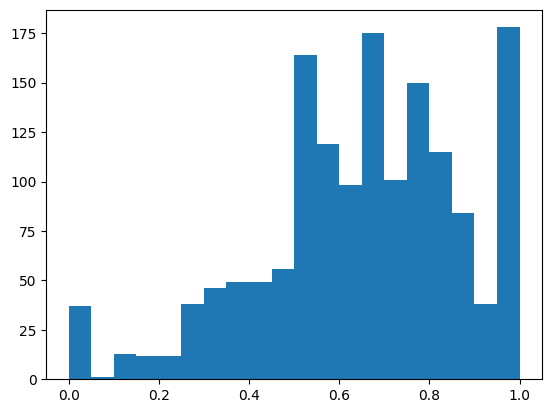

In [9]:
df = pd.read_csv(f"../generated_nle/GPT-J_COS-E/{data_name}_1535_1534_shap.csv")
import matplotlib.pyplot as plt
plt.hist(df['max_shap_value'], bins=20)

In [56]:
output_names = shap_values.output_names
output_names

["'", 'avoid', "'", '']

In [33]:
question_shap

array([[ 0.25499835,  0.51300572,  0.29760383],
       [ 0.25499835,  0.51300572,  0.29760383],
       [-0.11267167, -0.00426063, -0.16047739],
       [-0.11267167, -0.00426063, -0.16047739],
       [-0.10597808, -0.01795445, -0.1006442 ],
       [-0.10597808, -0.01795445, -0.1006442 ],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.15497902, -0.11018095, -0.09814789],
       [ 0.2207055 , -0.27186382, -0.14738744],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.11896509,  0.06768506,  0.08170149],
       [-0.64676863,  0.03660306, -0.19551068],
       [-0.64676863,  0.03660306, -0.19551068],
       [-0.21998275,  0.06297155, -0.67343732],
       [-0.19320152,  0.03467226, -0.8519333 ],
       [ 0.07975562, -0.19418687, -0.13615681],
       [ 0.07975562, -0.19418687, -0.136

In [13]:
shap_values.__dict__.keys()

dict_keys(['op_history', 'compute_time', 'output_dims', '_s'])

In [20]:
shap_values._s.__dict__.keys()

dict_keys(['_max_dim', '_anon', '_objects', '_aliases', '_alias_lookup', 'o', 'values', 'base_values', 'data', 'display_data', 'instance_names', 'feature_names', 'output_indexes', 'lower_bounds', 'upper_bounds', 'error_std', 'main_effects', 'hierarchical_values', 'clustering'])

In [42]:
output_list = list(shap_values._s._aliases['output_names'])
print(output_list, len(output_list))

['', "'", 'en', 'force', "'", '<|endoftext|>', '#', '', '<|endoftext|>', '#', '', ''] 12


In [44]:
def check_and_erase(source, target):
    bool_results = []
    true_ends = 0
    for x in source:
        if x == '':
            bool_results.append(False)
            continue
        if x in target:
            bool_results.append(True)
            true_ends = 1
            target = target.replace(x, "")
        else:
            if true_ends == 1:
                break
            bool_results.append(False)
    bool_results = bool_results + [False]*(len(source)-len(bool_results))
    return np.array(bool_results)
check_and_erase(output_list, 'enforce')

array([False, False,  True,  True, False, False, False, False, False,
       False, False, False])

In [34]:
output_list

['',
 "'",
 'en',
 'force',
 "'",
 '<|endoftext|>',
 '#',
 '',
 '<|endoftext|>',
 '#',
 '',
 '']

In [38]:
shap_values.values[0].shape

(72, 12)

In [10]:
shap.plots.text(shap_values)

## Training for the Probe

### Load Model

In [3]:
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
tokenizer = bert_model.tokenizer
sample_input = tokenizer(['heavy metal'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Get Data

In [4]:
# get the content between brackets
def get_bracket_content(s):
    return re.findall(r'\((.*?)\)', s)[0]

In [12]:
import ast
import re
# sample_df = pd.read_csv("../generated_nle/GPT-J_COS-E/COS-E_505_shap.csv")
file_prefix = 'COS-E_1535_1534'
file_prefix = 'COS-E_1525_1524'
sample_df = pd.read_csv(f"../generated_nle/GPT-J_COS-E/{file_prefix}_shap.csv")
# supplements = ["../COS-E_range(0, 1797)_shap.csv", "../COS-E_range(1797, 3594)_shap.csv"]
# final_df_len = 0
# for fname in supplements:
#     # range_tuple = re.findall(r'\((.*?)\)', fname)[0].split(', ')
#     # range_tuple = [int(x) for x in range_tuple]
#     if sample_df is None:
#         sample_df = pd.read_csv(fname)
#     else:
#         sample_df = pd.concat([sample_df, pd.read_csv(fname)], ignore_index=True)  
sample_df

id  \
0     075e483d21c29a511267ef62bedc0461   
1     61fe6e879ff18686d7552425a36344c8   
2     02e821a3e53cb320790950aab4489e85   
3     23505889b94e880c3e89cff4ba119860   
4     3d0f8824ea83ddcc9ab03055658b89d3   
...                                ...   
1512  709912a9876e824ea97da15170fd1716   
1513  95703127228d8b87b3fe998b1b2203e6   
1514  f7216534fcff2743cc94c29cb689ea71   
1515  374e8dc01ca7749d668ed66ac4044e70   
1516  f35bd5f5baf09e8836dd08cfe77a6d34   

                                               question           choice_0  \
0     The sanctions against the school were a punish...             ignore   
1     Sammy wanted to go to where the people were.  ...         race track   
2     Google Maps and other highway and street GPS s...      united states   
3     The fox walked from the city into the forest, ...    pretty flowers.   
4     The forgotten leftovers had gotten quite old, ...             carpet   
...                                                 ...                ...   
1512  Where might you have to pay for a shopping bag...         restaurant   
1513        Where would the Air Force keep an airplane?   airport terminal   
1514                       What is a computer terminal?  electrical device   
1515  She was known for be soft and sensitive, but w...      non sensitive   
1516  There are many dance clubs and higher rates of...      united states   

             choice_1         choice_2               choice_3  \
0             enforce    authoritarian                yell at   
1     populated areas       the desert              apartment   
2              mexico      countryside                  atlas   
3           hen house  natural habitat              storybook   
4        refrigerator         breadbox                 fridge   
...               ...              ...                    ...   
1512           closet     at starbucks            supermarket   
1513    military base              sky                 hanger   
1514          battery      electronics  transportation system   
1515        resistant            stoic               hardened   
1516             ohio             toun               michigan   

                   choice_4  label  \
0                     avoid      0   
1                 roadblock      1   
2                    oceans      3   
3              dense forest      2   
4                     coach      1   
...                     ...    ...   
1512                   home      3   
1513        airplane hangar      1   
1514                initial      0   
1515               uncaring      2   
1516  fast food restaurants      0   

                                  human_expl_open-ended  \
0           Not sure what else could be a common ground   
1                    People will be in populated areas.   
2     atlases were collections of highway and street...   
3     Usually the habitat of a fox is forest and it ...   
4               Becuase Leftovers are put in the fridge   
...                                                 ...   
1512  A supermarket is the only place one would need...   
1513            is the best since it is the best backup   
1514  An computer is an electrical device connected ...   
1515  Soft and senstive persons aren't expected to b...   
1516  United states are commonly associated with obe...   

                                                    nle  model_answer  \
0     The school's efforts to change were not enough...           1.0   
1     Sammy could go to a bustling city like Los Ang...           3.0   
2     Google Maps and other highway and city GPS ser...           3.0   
3     The fox was looking for a place in the forest ...           0.0   
4     The forgotten leftovers had gotten old and cov...           4.0   
...                                                 ...           ...   
1512       You can buy a shopping bag at a supermarket.           3.0   
1513  The Air Force would keep an airplane at a mili...        

In [23]:
bert_model.model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial
from transformers import AutoTokenizer

device = torch.device('cuda:0')

## use a tokenizer from the bert model
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)

class Distilbert_LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.bert_model = bert_model
        self.embedding = bert_model.model.distilbert.eval()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        with torch.no_grad():
            bert_embeddings = self.embedding(**x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(bert_embeddings.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out

class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(50265, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        embeddings = self.embedding(x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(embeddings)
        out = self.fc(out[:, -1, :])
        return out
        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        return nle_input, label  

# def collate_fn_base(data, tokenizer):
#     nle_input, label = zip(*data)
#     nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
#     nle_input = {k: v.to(device) for k, v in nle_input.items()}
#     return nle_input, torch.tensor(label).to(device).reshape(-1,1)

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = nle_input.input_ids.to(device)
    return nle_input, torch.tensor(label).to(device).reshape(-1,1)

# model = Distilbert_LSTM_regressor().to(device)
model = LSTM_regressor().to(device)

# tokenizer = bert_model.tokenizer
tokenizer = AutoTokenizer.from_pretrained('nlpcloud/instruct-gpt-j-fp16')
tokenizer.pad_token = tokenizer.eos_token
collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))

np.random.seed(42)
idxes = np.random.permutation(len(sample_df))

train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(len(train_dataset), len(val_dataset), len(test_dataset))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


1061 227 229


In [32]:
# best_val_loss = np.inf
best_peasonr = -np.inf
for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
    model.train()
    y_true, y_pred, train_loss = [], [], []
    for (xs, ys) in train_dataloader:
        model.zero_grad()
        out = model(xs)
        loss = criterion(out, ys)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        y_true.append(ys.detach().cpu().numpy().flatten())
        y_pred.append(out.detach().cpu().numpy().flatten())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    train_loss = np.mean(train_loss)
    train_PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]

    model.eval()
    y_true, y_pred, val_loss = [], [], []
    for (xs, ys) in val_dataloader:
        with torch.no_grad():
            out = model(xs)
        y_true.append(ys.cpu().numpy().flatten())
        y_pred.append(out.cpu().numpy().flatten())
        loss = criterion(out, ys)
        val_loss.append(loss.item())
    val_loss = np.mean(val_loss)
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
    print(f'epoch: {epoch}, train_loss {train_loss:.3f}, PearsonR: {train_PearsonR:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
    if PearsonR > best_peasonr:
        best_peasonr = PearsonR
        torch.save(model.state_dict(), f'../generated_nle/{exp_name}/{file_prefix}_best_model.pth')
        print('saved best model')

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0, train_loss 0.475, PearsonR: -0.099, val_loss: 0.241, PearsonR: -0.011
saved best model
epoch: 1, train_loss 0.449, PearsonR: -0.002, val_loss: 0.242, PearsonR: -0.017
epoch: 2, train_loss 0.444, PearsonR: 0.016, val_loss: 0.246, PearsonR: -0.028
epoch: 3, train_loss 0.450, PearsonR: -0.010, val_loss: 0.239, PearsonR: 0.012
saved best model
epoch: 4, train_loss 0.453, PearsonR: -0.033, val_loss: 0.241, PearsonR: -0.059
epoch: 5, train_loss 0.445, PearsonR: 0.018, val_loss: 0.242, PearsonR: -0.048
epoch: 6, train_loss 0.449, PearsonR: -0.001, val_loss: 0.241, PearsonR: -0.011
epoch: 7, train_loss 0.443, PearsonR: 0.054, val_loss: 0.244, PearsonR: -0.050
epoch: 8, train_loss 0.444, PearsonR: 0.024, val_loss: 0.242, PearsonR: -0.040
epoch: 9, train_loss 0.445, PearsonR: 0.032, val_loss: 0.247, PearsonR: -0.007
epoch: 10, train_loss 0.451, PearsonR: 0.058, val_loss: 0.246, PearsonR: -0.006
epoch: 11, train_loss 0.445, PearsonR: 0.027, val_loss: 0.250, PearsonR: -0.031
epoch: 12, t

In [ ]:

datasets_dict = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

model.load_state_dict(torch.load(f'../generated_nle/{exp_name}/{file_prefix}_best_model.pth'))
model.eval()

import ipywidgets as widgets
@widgets.interact(split=['train', 'val', 'test'])
def eval_for_datast(split):
    some_dataset = datasets_dict[split]
    some_dataloader = DataLoader(some_dataset,
        batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    y_pred, y_true, xs_len = [], [], []
    for (xs, ys) in (disc:=tqdm(some_dataloader)):
        with torch.no_grad():
            out = model(xs)
        y_pred.append(out.cpu().numpy())
        y_true.append(ys.cpu().numpy())
        # disc.set_description(f'loss: {loss.item():.3f}')
    y_pred = np.vstack(y_pred).flatten()
    y_true = np.vstack(y_true).flatten()
    MAE = np.abs(y_pred - y_true)
    sent_len = [len(x.split(" ")) for x in some_dataset.df.question]
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)
    Loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    print(f'PearsonR: {PearsonR[0]:.3f}, p-value: {PearsonR[1]:.3f}, loss: {Loss:.3f}')
    plt.scatter(y_pred, y_true, alpha=0.5)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()  
    PearsonR = scipy.stats.pearsonr(sent_len, MAE)
    print(f'PearsonR: {PearsonR[0]:.3f}') 
    plt.scatter(sent_len, MAE, alpha=0.5)
    plt.show()
    @widgets.interact(idx=(0, len(some_dataset)-1))
    def show_sample(idx):
        x, y = some_dataset[idx]
        nle = tokenizer(x, return_tensors="pt", padding=True)
        nle = {k: v.to(device) for k, v in nle.items()}
        model.eval()
        with torch.no_grad():
            out = model(nle)
        # out, sample_df.max_shap_value[0]
        print(f'predicted: {out.item():.3f}, actual: {y:.3f}')
        print(f'input: {x}')


interactive(children=(Dropdown(description='split', options=('train', 'val', 'test'), value='train'), Output()…

: 

In [ ]:
# get max numbers